In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models,transforms
import Images_helper

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [3]:
model = models.vgg19(pretrained=True).features
model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [4]:
for param in model.parameters():
    param.requires_grad_(False) #stop all parameters gradient calculation to stop learning

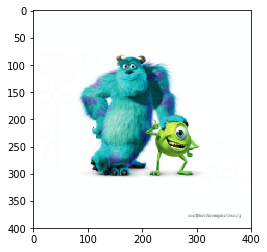

In [34]:
content = Images_helper.load_image("Images/monstersInc.jpg",400,[0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
plt.imshow(Images_helper.Tensor_to_Image(content,[0.485, 0.456, 0.406],[0.229, 0.224, 0.225]))

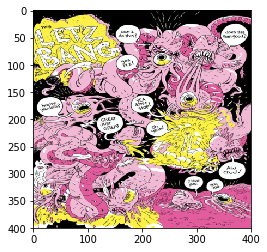

In [35]:
style = Images_helper.load_image("Images/ben_passmore.jpg",400,[0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
plt.imshow(Images_helper.Tensor_to_Image(style,[0.485, 0.456, 0.406],[0.229, 0.224, 0.225]))

In [36]:
#key : layer number from the model in third cell => value : string representing name
style_layers = {
          '0' : 'conv1_1',
          '5' : 'conv2_1',
          '10' : 'conv3_1',
          '19' : 'conv4_1',
          '28' : 'conv5_1' 
         } 

content_layers = {'21' : 'conv4_2'} 

def get_layer_features(image,layers):
    features = {}
    imgtmp = image
    for number, layer in model._modules.items():
        imgtmp = layer(imgtmp)
        if number in layers:
            features[layers[number]] = imgtmp
    return features

def get_gram_matrix(tensor):
    #batchsize always 1
    batchsize, depth, height, width = tensor.size()
    tensor = tensor.view(depth,height*width)
    Gmatrix = torch.mm(tensor,tensor.t())
    return Gmatrix#.div(batchsize*depth*height*width)

In [37]:
def calc_content_loss(content_image,target_image):
    return torch.mean((content_image-target_image)**2)
def calc_style_loss(style_features,target_features,weights,d,h,w,a=0.8):
    loss = 0
    for layer in style_features:
        #_,d,h,w = style_features[layer].shape
        loss += (weights[layer] * torch.mean((target_features[layer]-style_features[layer])**2))/(d*h*w)
    return loss * a

Total loss:  34876391424.0


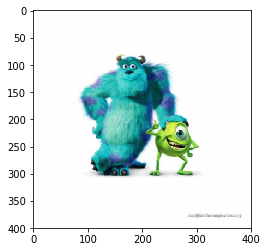

Total loss:  3620035072.0


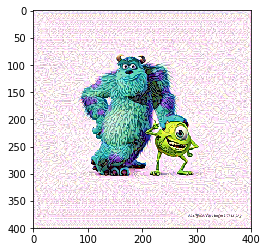

Total loss:  1465420416.0


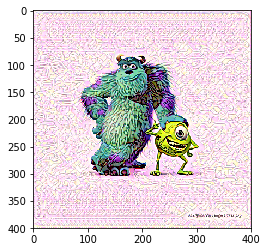

Total loss:  749747264.0


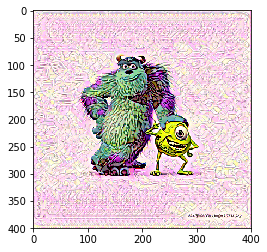

Total loss:  433717376.0


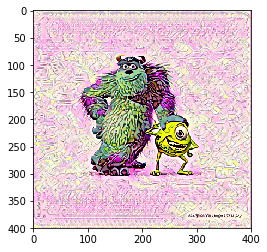

Total loss:  269778688.0


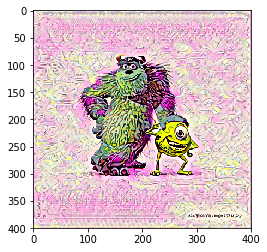

Total loss:  176916272.0


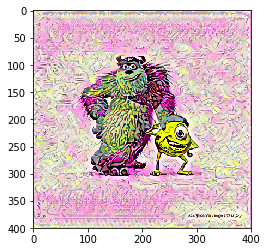

Total loss:  121546040.0


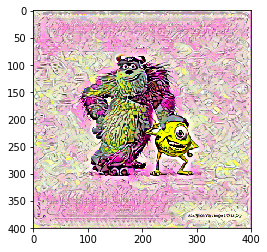

Total loss:  87265664.0


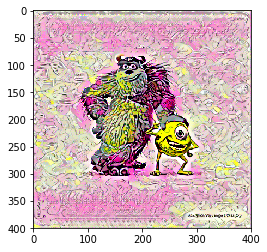

Total loss:  64924732.0


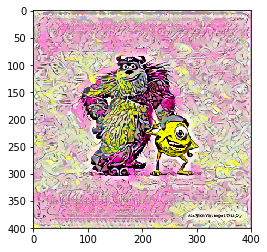

Final Result


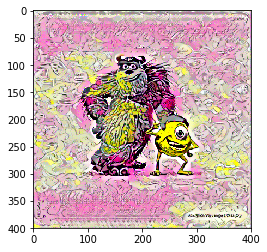

In [40]:
#loss weights
content_weight = 1 #alpha 
style_weight = 1e6 #omega
style_layers_weights = {'conv1_1' : 1,
                        'conv2_1' : 0.75,
                        'conv3_1' : 0.2,
                        'conv4_1' : 0.2,
                        'conv5_1' : 0.2}

iterations = 5000
show_every = 500

#get content and style images features before loop cause they will never change
content = content.to(device)
style = style.to(device)
content_image_features = get_layer_features(content,content_layers)
style_image_features = get_layer_features(style,style_layers)
#calc style grams
style_grams = {layer : get_gram_matrix(style_image_features[layer]) for layer in style_image_features}


# create a third "target" image and prep it for change
# it is a good idea to start of with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

#optimizer
optimizer = optim.Adam([target],lr=0.003)
_,d,h,w = target.size()
for i in range(iterations):
    target_content_features = get_layer_features(target , content_layers)
    
    target_style_features = get_layer_features(target,style_layers)
    target_grams = {layer : get_gram_matrix(target_style_features[layer]) for layer in target_style_features}
    
    #calc loss
    content_loss = calc_content_loss(content_image_features['conv4_2'],target_content_features['conv4_2'])
    style_loss =  calc_style_loss(style_grams,target_grams,style_layers_weights,d,h,w)
    
    total_loss = (style_loss * style_weight) + (content_loss * content_weight)
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    if  i % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(Images_helper.Tensor_to_Image(target.cpu(),[0.485, 0.456, 0.406],[0.229, 0.224, 0.225]))
        plt.show()
print('Final Result')
plt.imshow(Images_helper.Tensor_to_Image(target.cpu(),[0.485, 0.456, 0.406],[0.229, 0.224, 0.225]))
plt.show()    

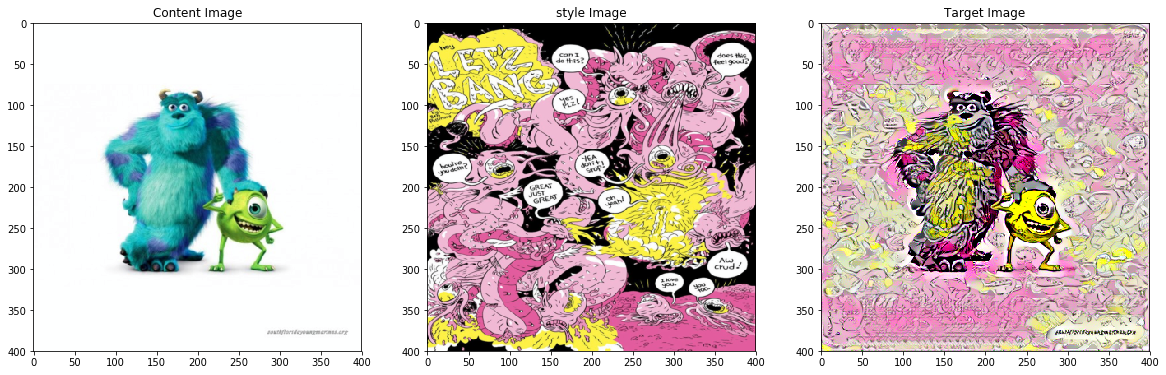

In [41]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(131)
plt.imshow(Images_helper.Tensor_to_Image(content.cpu(),[0.485, 0.456, 0.406],[0.229, 0.224, 0.225]))
ax.set_title("Content Image")

ax = fig.add_subplot(132)
plt.imshow(Images_helper.Tensor_to_Image(style.cpu(),[0.485, 0.456, 0.406],[0.229, 0.224, 0.225]))
ax.set_title("style Image")

ax = fig.add_subplot(133)
plt.imshow(Images_helper.Tensor_to_Image(target.cpu(),[0.485, 0.456, 0.406],[0.229, 0.224, 0.225]))
ax.set_title("Target Image")


plt.show()